# Fake News Classification:

# Import Libraries:

In [1]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import urllib
import cv2
import random

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Data Cleaning and Analysis:

In [2]:
tr_data=pd.read_csv("multimodal_train.tsv",sep="\t")
vl_data=pd.read_csv('multimodal_validate.tsv',sep="\t")
te_data=pd.read_csv('multimodal_test_public.tsv',sep="\t")

print(tr_data.shape)
print(vl_data.shape)
print(te_data.shape)

(564000, 16)
(59342, 16)
(59319, 16)


In [3]:
tr_data.describe()

,created_utc,num_comments,score,upvote_ratio,2_way_label,3_way_label,6_way_label
count,5.640000e+05,396143.000000,564000.000000,396143.000000,564000.000000,564000.000000,564000.000000
mean,1.478727e+09,20.363525,395.449160,0.855361,0.393761,1.187926,1.884012
std,6.970407e+07,141.460211,3049.910636,0.110111,0.488583,0.969604,1.782309
min,1.212297e+09,0.000000,-950.000000,0.500000,0.000000,0.000000,0.000000
25%,1.418176e+09,1.000000,5.000000,0.780000,0.000000,0.000000,0.000000
50%,1.488981e+09,2.000000,14.000000,0.880000,0.000000,2.000000,2.000000
75%,1.550486e+09,7.000000,46.000000,0.940000,1.000000,2.000000,4.000000
max,1.573859e+09,10783.000000,137179.000000,1.000000,1.000000,2.000000,5.000000


In [4]:
tr_data["hasImage"].describe()

count     564000
unique         1
top         True
freq      564000
Name: hasImage, dtype: object

In [5]:
tr_data.isnull().sum()

author                   28710
clean_title                  0
created_utc                  0
domain                  167857
hasImage                     0
id                           0
image_url                 1534
linked_submission_id    396143
num_comments            167857
score                        0
subreddit                    0
title                        0
upvote_ratio            167857
2_way_label                  0
3_way_label                  0
6_way_label                  0
dtype: int64

In [6]:
vl_data.isnull().sum()

author                   3063
clean_title                 0
created_utc                 0
domain                  17810
hasImage                    0
id                          0
image_url                 173
linked_submission_id    41532
num_comments            17810
score                       0
subreddit                   0
title                       0
upvote_ratio            17810
2_way_label                 0
3_way_label                 0
6_way_label                 0
dtype: int64

In [7]:
te_data.isnull().sum()

author                   3068
clean_title                 0
created_utc                 0
domain                  17472
hasImage                    0
id                          0
image_url                 156
linked_submission_id    41847
num_comments            17472
score                       0
subreddit                   0
title                       0
upvote_ratio            17472
2_way_label                 0
3_way_label                 0
6_way_label                 0
dtype: int64

In [8]:
tr_data["domain"].value_counts()[:5]

i.redd.it              176260
i.imgur.com             74782
imgur.com               29656
i.reddituploads.com      3997
theonion.com             3714
Name: domain, dtype: int64

In [9]:
tr_data["num_comments"].value_counts()[:5]

0.0    94725
1.0    61657
2.0    44296
3.0    32610
4.0    24630
5.0    18434
Name: num_comments, dtype: int64

In [10]:
tr_data["num_comments"]=tr_data["num_comments"].replace(np.nan,0)
vl_data["num_comments"]=vl_data["num_comments"].replace(np.nan,0)
te_data["num_comments"]=te_data["num_comments"].replace(np.nan,0)

In [11]:
tr_data["score"].value_counts()[:5]

2    37329
3    34478
1    27650
5    24870
4    23594
Name: score, dtype: int64

In [12]:
tr_data["score"]=tr_data["score"].replace(np.nan,2)
vl_data["score"]=vl_data["score"].replace(np.nan,2)
te_data["score"]=te_data["score"].replace(np.nan,2)

tr_data["upvote_ratio"]=tr_data["upvote_ratio"].replace(np.nan,1.0)
vl_data["upvote_ratio"]=vl_data["upvote_ratio"].replace(np.nan,1.0)
te_data["upvote_ratio"]=te_data["upvote_ratio"].replace(np.nan,1.0)

tr_data=tr_data.drop(['hasImage','author','id','domain','linked_submission_id','title'],axis=1)
vl_data=vl_data.drop(['hasImage','author','id','domain','linked_submission_id','title'],axis=1)
te_data=te_data.drop(['hasImage','author','id','domain','linked_submission_id','title'],axis=1)

In [13]:

tr_data["subreddit"].value_counts()

psbattle_artwork         167857
mildlyinteresting         86237
photoshopbattles          55198
pareidolia                47331
fakehistoryporn           35576
nottheonion               31977
upliftingnews             23960
fakealbumcovers           21725
misleadingthumbnails      15962
propagandaposters         13848
subredditsimulator        11553
confusing_perspective      8352
savedyouaclick             7721
theonion                   7548
neutralnews                7512
usnews                     5941
usanews                    5875
pic                        5381
satire                     3845
waterfordwhispersnews       363
subsimulatorgpt2            231
fakefacts                     7
Name: subreddit, dtype: int64

In [14]:
tr_data.dropna(axis=0,inplace=True)
vl_data.dropna(axis=0,inplace=True)
te_data.dropna(axis=0,inplace=True)
print(tr_data.shape)
print(vl_data.shape)
print(te_data.shape)


(562466, 10)
(59169, 10)
(59163, 10)


In [15]:
tr_samp_data=tr_data[tr_data["6_way_label"]==0][:6000]
tr_samp_data=tr_samp_data.append(tr_data[tr_data["6_way_label"]==1][:6000])
tr_samp_data=tr_samp_data.append(tr_data[tr_data["6_way_label"]==2][:6000])
tr_samp_data=tr_samp_data.append(tr_data[tr_data["6_way_label"]==3][:6000])
tr_samp_data=tr_samp_data.append(tr_data[tr_data["6_way_label"]==4][:6000])
tr_samp_data=tr_samp_data.append(tr_data[tr_data["6_way_label"]==5][:6000])
tr_samp_data.head(2)

,clean_title,created_utc,image_url,num_comments,score,subreddit,upvote_ratio,2_way_label,3_way_label,6_way_label
0,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,https://external-preview.redd.it/WylDbZrnbvZdB...,2.0,12,mildlyinteresting,0.84,1,0,0
2,hackers leak emails from uae ambassador to us,1.496511e+09,https://external-preview.redd.it/6fNhdbc6K1vFA...,1.0,44,neutralnews,0.92,1,0,0


In [16]:
vl_samp_data=vl_data[vl_data["6_way_label"]==0][:1000]
vl_samp_data=vl_samp_data.append(vl_data[vl_data["6_way_label"]==1][:1000])
vl_samp_data=vl_samp_data.append(vl_data[vl_data["6_way_label"]==2][:1000])
vl_samp_data=vl_samp_data.append(vl_data[vl_data["6_way_label"]==3][:1000])
vl_samp_data=vl_samp_data.append(vl_data[vl_data["6_way_label"]==4][:1000])
vl_samp_data=vl_samp_data.append(vl_data[vl_data["6_way_label"]==5][:1000])
vl_samp_data.head(2)

,clean_title,created_utc,image_url,num_comments,score,subreddit,upvote_ratio,2_way_label,3_way_label,6_way_label
0,my xbox controller says hi,1.567436e+09,https://preview.redd.it/l0ga0tug17k31.jpg?widt...,4.0,25,mildlyinteresting,0.72,1,0,0
1,new image from the mandalorian,1.567745e+09,https://external-preview.redd.it/VX7bXDu9Gl8UZ...,5.0,21,photoshopbattles,0.92,1,0,0


In [17]:
te_samp_data=te_data[te_data["6_way_label"]==0][:1000]
te_samp_data=te_samp_data.append(te_data[te_data["6_way_label"]==1][:1000])
te_samp_data=te_samp_data.append(te_data[te_data["6_way_label"]==2][:1000])
te_samp_data=te_samp_data.append(te_data[te_data["6_way_label"]==3][:1000])
te_samp_data=te_samp_data.append(te_data[te_data["6_way_label"]==4][:1000])
te_samp_data=te_samp_data.append(te_data[te_data["6_way_label"]==5][:1000])
te_samp_data.head(2)

,clean_title,created_utc,image_url,num_comments,score,subreddit,upvote_ratio,2_way_label,3_way_label,6_way_label
2,pd phoenix car thief gets instructions from yo...,1.560492e+09,https://external-preview.redd.it/1A2_4VwgS8Qd2...,2.0,16,nottheonion,0.89,1,0,0
3,as trump accuses iran he has one problem his o...,1.560606e+09,https://external-preview.redd.it/9BKRcgvaobpTo...,4.0,45,neutralnews,0.78,1,0,0


# Average Word2Vec for Text Data:

In [18]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

def preprocess_sent(line):
    phrase=[stemmer.stem(l) for l in line.split()]
    phrase=[l for l in phrase if l not in stopwords]
    phrase=" ".join(phrase)
    return phrase
preprocess_sent("man is calm and better")

'man calm better'

In [19]:
train_sentences=[]

for sent in tqdm(list(tr_samp_data["clean_title"].values)):
    train_sentences.append(preprocess_sent(sent))

import pickle
with open('word2vec_model', 'rb') as f:
    w2v_model = pickle.load(f)
    w2v_words =  set(w2v_model.keys())

    
train_sent_vectors = []; 
for sent in tqdm(train_sentences):
    sent_vec = np.zeros(300)
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_sent_vectors.append(sent_vec)
print(len(train_sent_vectors))
print(len(train_sent_vectors[0]))

train_sent_vectors=np.array(train_sent_vectors)

100%|█████████████████████████████████████████████████████████████████████████| 36000/36000 [00:02<00:00, 17503.98it/s]

36000
300


In [20]:
valid_sentences=[]

for sent in tqdm(list(vl_samp_data["clean_title"].values)):
    valid_sentences.append(preprocess_sent(sent))


valid_sent_vectors = []; 
for sent in tqdm(valid_sentences):
    sent_vec = np.zeros(300)
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    valid_sent_vectors.append(sent_vec)
print(len(valid_sent_vectors))
print(len(valid_sent_vectors[0]))

valid_sent_vectors=np.array(valid_sent_vectors)

100%|███████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 18218.36it/s]

6000
300


In [21]:
test_sentences=[]

for sent in tqdm(list(te_samp_data["clean_title"].values)):
    test_sentences.append(preprocess_sent(sent))


test_sent_vectors = []; 
for sent in tqdm(test_sentences):
    sent_vec = np.zeros(300)
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_sent_vectors.append(sent_vec)
print(len(test_sent_vectors))
print(len(test_sent_vectors[0]))

test_sent_vectors=np.array(test_sent_vectors)

100%|███████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 17757.94it/s]

6000
300


# Data Preparation:

In [22]:
from tensorflow.keras import applications
from tensorflow.keras.layers import Input

import tensorflow as tf 


model = applications.VGG16(weights="imagenet")

model.layers.pop()
model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [23]:
with open('tr_img_0to10k.pkl', 'rb') as f:
    train_images = pickle.load(f)
with open('tr_img_10kto20k.pkl', 'rb') as f:
    train_images.extend(pickle.load(f))
with open('tr_img_20kto36k.pkl', 'rb') as f:
    train_images.extend(pickle.load(f))

In [24]:
with open('tr_vgg_features.pkl', 'rb') as f:
    train_features = pickle.load(f)
 
train_features = np.array(train_features)    
train_features = train_features.reshape(35555,4096)

In [25]:
from sklearn.decomposition import PCA

train_features = PCA(n_components=10).fit_transform(train_features)

In [26]:
ind=[]

for i in tqdm(range(36000)):
    if train_images[i]=='nan':
        continue
    ind.append(i)
    
train_images=np.array(train_images)[ind]

train_sent_vectors=train_sent_vectors[ind]

y_train=np.array(tr_samp_data['6_way_label'])[ind]


x1=np.array(tr_samp_data[[ 'created_utc', 'num_comments', 'score',
        'upvote_ratio', '2_way_label', '3_way_label']].values)
x1=x1[ind]

from sklearn.preprocessing import OneHotEncoder 
enc1 = OneHotEncoder() 

enc = enc1.fit_transform(tr_samp_data[['subreddit']]).toarray() 

enc=enc[ind]
x2=np.hstack((x1,enc))
x=np.hstack((train_sent_vectors,x2))

100%|████████████████████████████████████████████████████████████████████████| 36000/36000 [00:00<00:00, 145300.33it/s]


In [27]:
x=np.hstack((train_features,x))

In [29]:
with open('val_images.pkl', 'rb') as f:
    valid_images = pickle.load(f)
    
ind=[]

for i in tqdm(range(6000)):
    if valid_images[i]=='nan':
        continue
    ind.append(i)
    
valid_images=np.array(valid_images)[ind]

valid_sent_vectors=valid_sent_vectors[ind]

y_val=np.array(vl_samp_data['6_way_label'])[ind]


x1=np.array(vl_samp_data[[ 'created_utc', 'num_comments', 'score',
        'upvote_ratio', '2_way_label', '3_way_label']].values)
x1=x1[ind]



enc = enc1.fit_transform(vl_samp_data[['subreddit']]).toarray() 

enc=enc[ind]
x2=np.hstack((x1,enc))
v=np.hstack((valid_sent_vectors,x2))

100%|███████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 74745.68it/s]


In [30]:
valid_features=[]


for i in tqdm(range(valid_images.shape[0])):
    image= cv2.resize(valid_images[i], (224,224))
    img=image.reshape(1,224,224,3)
    
    valid_features.append(model.predict(img))
    
valid_features=np.array(valid_features)

valid_features=valid_features.reshape(5909,4096)

from sklearn.decomposition import PCA

valid_features = PCA(n_components=10).fit_transform(valid_features)

v=np.hstack((valid_features,v))

100%|████████████████████████████████████████████████████████████████████████████| 5909/5909 [5:09:44<00:00,  3.15s/it]


In [33]:
with open('test_images.pkl', 'rb') as f:
    test_images = pickle.load(f)
    
ind=[]

for i in tqdm(range(6000)):
    if test_images[i]=='nan':
        continue
    ind.append(i)
    
test_images=np.array(test_images)[ind]

test_sent_vectors=test_sent_vectors[ind]

y_test=np.array(te_samp_data['6_way_label'])[ind]


x1=np.array(te_samp_data[[ 'created_utc', 'num_comments', 'score',
        'upvote_ratio', '2_way_label', '3_way_label']].values)
x1=x1[ind]

 
enc = enc1.transform(te_samp_data[['subreddit']]).toarray() 

enc=enc[ind]
x2=np.hstack((x1,enc))
t=np.hstack((test_sent_vectors,x2))

100%|██████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 113509.38it/s]


In [34]:
test_features=[]


for i in tqdm(range(test_images.shape[0])):
    image= cv2.resize(test_images[i], (224,224))
    img=image.reshape(1,224,224,3)
    
    test_features.append(model.predict(img))
    
test_features=np.array(test_features)

test_features=test_features.reshape(5910,4096)

from sklearn.decomposition import PCA

test_features = PCA(n_components=10).fit_transform(test_features)

x_test=np.hstack((test_features,t))

100%|██████████████████████████████████████████████████████████████████████████████| 5910/5910 [53:32<00:00,  1.84it/s]


# Train and validation data:

In [35]:
tr_ind=random.sample(range(0,x.shape[0]),x.shape[0])

x_train,y_train=x[tr_ind],y_train[tr_ind]

vl_ind=random.sample(range(0,v.shape[0]),v.shape[0])

x_val,y_val=v[vl_ind],y_val[vl_ind]

# Model Training:

# Decision Tree:

In [36]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)

# Hyperparameter Tuning:

In [37]:
max_dep=[3,5,8,11]

min_split=[5,10,20,50]

In [38]:
from sklearn.metrics import accuracy_score

train_auc=[]
cv_auc=[]
for i in max_dep:
    p=[]
    q=[]
    for j in min_split:
        clf=DecisionTreeClassifier(min_samples_split=j,max_depth=i)
        clf.fit(x_train,y_train)
        y_train_pred=clf.predict(x_train)
        y_cv_pred=clf.predict(x_val)
        p.append(accuracy_score(y_train,y_train_pred))
        q.append(accuracy_score(y_val,y_cv_pred))
    train_auc.append(p)
    cv_auc.append(q)

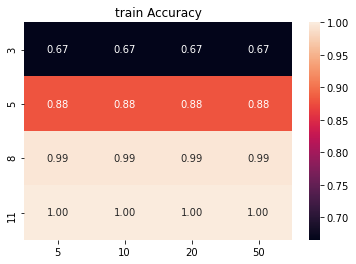

In [39]:
plt.title('train Accuracy')
plt.xlabel('min sample split')
plt.ylabel('max depth')
sns.heatmap(train_auc,annot=True,fmt='.2f',xticklabels=min_split,yticklabels=max_dep)
plt.show()

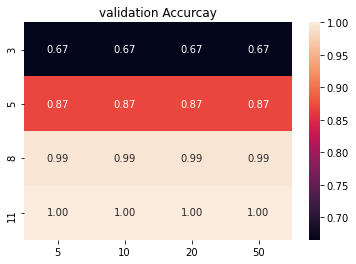

In [44]:
plt.title('validation Accurcay')
plt.xlabel('min sample split')
plt.ylabel('max depth')
sns.heatmap(cv_auc,annot=True,fmt='.2f',xticklabels=min_split,yticklabels=max_dep)
plt.show()

# prediction on test data:

In [45]:
clf = DecisionTreeClassifier(min_samples_split=5,max_depth=11).fit(x_train,y_train)

y_pred=clf.predict(x_test)


print("test accuracy is : "+str(accuracy_score(y_test,y_pred)))

test accuracy is : 1.0


# Extra Tree Clssifier:

In [56]:
from sklearn.ensemble import ExtraTreesClassifier

mnb = ExtraTreesClassifier( random_state=0)

# Hyperparamter Tuning:

In [57]:
n_est=[10,20,50,100,200]
train_acc=[]
cv_acc=[]
for i in tqdm(n_est):
    mnb=ExtraTreesClassifier(n_estimators=i, random_state=0)
    mnb.fit(x_train,y_train)
    y_train_pred=mnb.predict(x_train)
    y_cv_pred=mnb.predict(x_val)
    train_acc.append(accuracy_score(y_train,y_train_pred))
    cv_acc.append(accuracy_score(y_val,y_cv_pred))

100%|██████████| 5/5 [00:43<00:00,  8.65s/it]


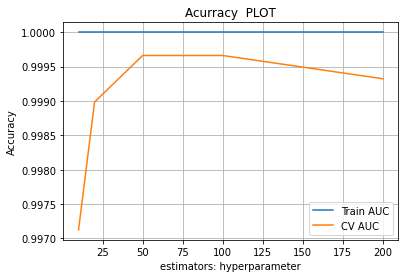

In [59]:
plt.plot(n_est, train_acc, label='Train AUC')
plt.plot(n_est, cv_acc, label='CV AUC')
plt.legend()
plt.xlabel("estimators: hyperparameter")
plt.ylabel("Accuracy")
plt.title("Acurracy  PLOT")
plt.grid()
plt.show()  

# Prediction on Test Data:

In [60]:
mnb=ExtraTreesClassifier(n_estimators=50, random_state=0).fit(x_train,y_train)

y_pred=mnb.predict(x_test)


print("test accuracy is : "+str(accuracy_score(y_test,y_pred)))

test accuracy is : 0.9989847715736041


# Random Forest Classifier:

In [46]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier()

# Hyperparameter Tuning:

In [47]:
estimator=[1,2,4,8,16,32,64,100,200]
max_dep=np.linspace(1,25,10,dtype=int)
train_acc=[]
cv_acc=[]
for i in tqdm(max_dep):
    p=[]
    q=[]
    for j in estimator:
        clf=RandomForestClassifier(n_estimators=j,max_depth=i)
        clf.fit(x_train,y_train)
        y_train_pred=clf.predict(x_train)
        y_cv_pred=clf.predict(x_val)
        p.append(accuracy_score(y_train,y_train_pred))
        q.append(accuracy_score(y_val,y_cv_pred))
    train_acc.append(p)
    cv_acc.append(q)

100%|██████████| 10/10 [30:44<00:00, 184.42s/it]


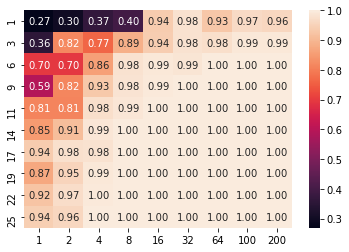

In [53]:
sns.heatmap(train_acc,annot=True,fmt='.2f',xticklabels=['1','2','4','8','16','32','64','100','200'],yticklabels=['1','3','6','9','11','14','17','19','22','25'])

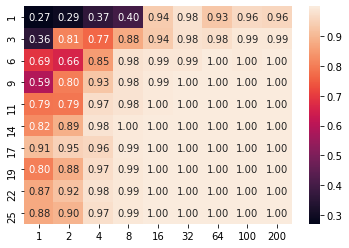

In [54]:
sns.heatmap(cv_acc,annot=True,fmt='.2f',xticklabels=['1','2','4','8','16','32','64','100','200'],yticklabels=['1','3','6','9','11','14','17','19','22','25'])

# Prediction on Test Data:

In [55]:
clf=RandomForestClassifier(n_estimators=32,max_depth=9).fit(x_train,y_train)

y_pred=clf.predict(x_test)


print("test accuracy is : "+str(accuracy_score(y_test,y_pred)))

test accuracy is : 0.9967851099830796
